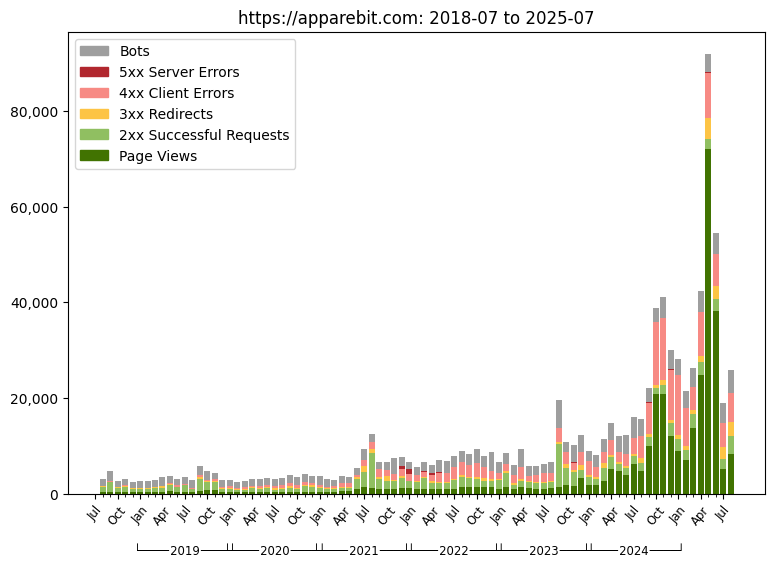

In [1]:
# Import modules. Ingest, validate, and summarize logs.
import konsole
konsole.config(level=konsole.WARNING)

from http import HTTPStatus
from IPython.display import display, HTML
import pandas as pd
import analog
from analog.ipaddr import HostnameDb, LocationDb
from analog.label import APPAREBIT_COOL_PATHS

manager = analog.latest_manager(root = "data")
full_data = manager.data
analog.validate(full_data)
fluent_data = analog.analyze(full_data)
monthly_summary = analog.summarize(full_data)

section_number = 0
def sec() -> int:
    global section_number
    section_number += 1
    return section_number

display(HTML(f"<h2 id=traffic-summary>{sec()}. Traffic Summary</h2>"))
analog.plot_monthly_summary(monthly_summary)
None

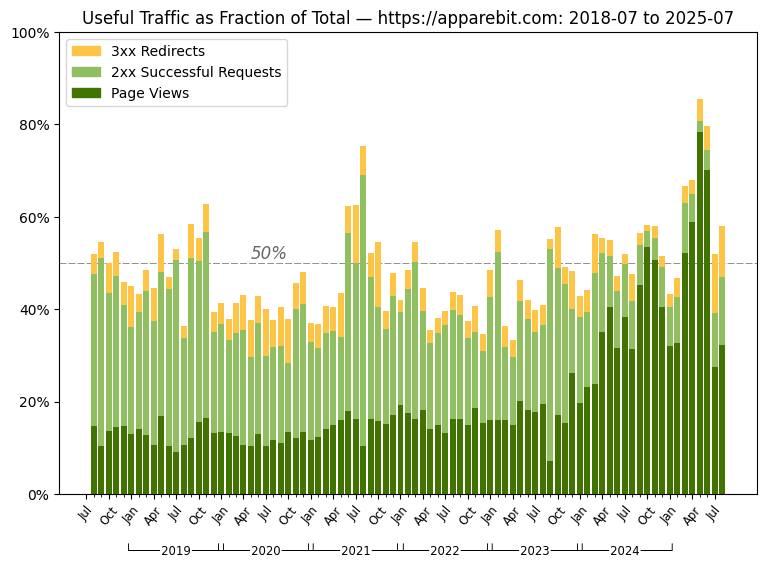

In [2]:
# Plot fraction of useful traffic
analog.plot_monthly_percentage(monthly_summary)
None

In [3]:
current_section = sec()
display(HTML(f"<h2 id=ip-address>{current_section}. IP Addresses Issuing the Most Requests</h2>"))

display(HTML(
    """\
    <p>We fundamentally need some token that uniquely identifies users.
    The IP address is a reasonable approximation that also lets us
    determine the hosting company for the node. That matters for abuse
    detection.</p>
    """
))

hostname_db = HostnameDb(manager.hostname_db)
location_db = LocationDb(manager.location_db)

def identify(addr):
    name = hostname_db.lookup(addr)
    if name is None:
        return name
    return ".".join(name.split(".")[-3:])

def locate(addr):
    location = location_db.lookup(addr)
    city = location.city.name
    country = location.country.iso_code
    return f"{city}, {country}"

def prep(label, data):
    df = (
        data
        .value_counts("client_address")
        .data
        .head(10)
        .reset_index()
    )

    df["domain"] = df["client_address"].map(identify, na_action="ignore")
    df["location"] = df["client_address"].map(locate, na_action="ignore")
    df.columns = pd.MultiIndex.from_arrays([[label] * 4, df.columns])
    return df.style.format(thousands=",")

try:
    display(HTML(f"<h3>{current_section}.1. Over Most Recent Month"))
    display(prep("last_month", fluent_data.over.last_month()))

    display(HTML(f"<h3>{current_section}.2. Over Most Recent Year"))
    display(prep("last_year", fluent_data.over.last_month()))

    display(HTML(f"<h3>{current_section}.3. Over All Time"))
    display(prep("all_time", fluent_data))
finally:
    location_db.close()
None

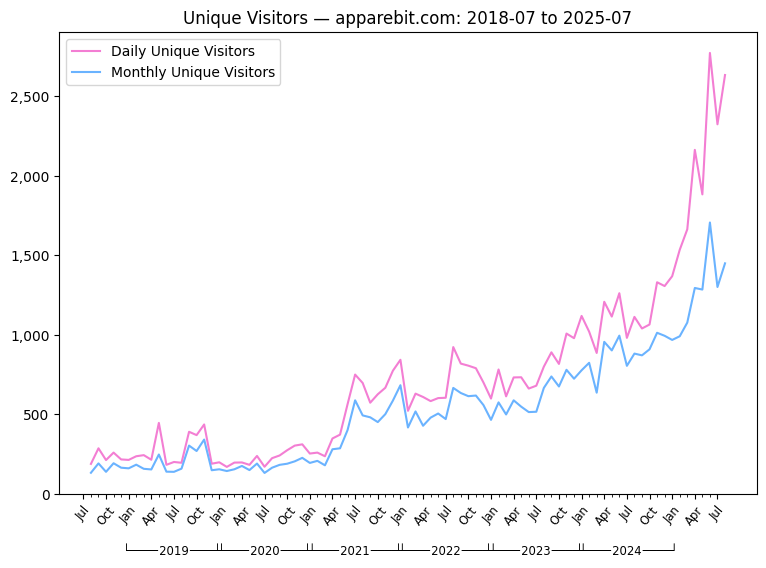

In [4]:
display(HTML(f"<h2 id=unique-visitors>{sec()}. Unique Visitors</h2>"))
analog.plot_visitors(monthly_summary)
None

In [5]:

def describe(out_of_policy: int, data: pd.DataFrame, column: str, unit: str) -> str:
    if out_of_policy == 0:
        return "✅ No months are"
    elif out_of_policy == 1:
        year, month = data.index[0]
        quant = data[column].iat[0]
        return f"⚠️ {year}-{month:02d} has {quant:,d} {unit} and hence is"
    else:
        return f"🛑 {out_of_policy} months are"

txt = f"<hr><h2 id=font-licensing>{sec()}. Font Licensing</h2>\n<p>"

dt = monthly_summary.data
too_many_views = dt[50_000 < dt["page_views"]]
out_of_policy = too_many_views.shape[0]

txt += describe(out_of_policy, too_many_views, "page_views", "page views")
txt += " out of policy for Bely's license limit of 50,000 page views per month."
if out_of_policy == 1 and too_many_views.index[0] == (2025, 4):
    txt += f" However, see <a href=#april-2025-as-outlier>Section {section_number + 1}</a> below."
txt += "\n<p>"

too_many_visitors = dt[15_000 < dt["monthly_visitors"]]
out_of_policy = too_many_visitors.shape[0]

txt += describe(out_of_policy, too_many_visitors, "monthly_visitors", "page visits")
txt += " out of policy for Bild's license limit of 15,000 unique monthly visitors.\n<p>"

txt += "\n<p>The unique monthly visitors are computed based on a heuristic that is also <a "
txt += "href='https://plausible.io/data-policy#how-we-count-unique-users-without-cookies'>used "
txt += "by Plausible analytics</a>. It counts unique tags computed by concatenating "
txt += "the date, the client IP address, and the user agent for non-bot page views."

display(HTML(txt))

In [6]:
# Page rank
def page_rank(label: str, data):
    df = (
        data
        .only.successful()
        .only.GET()
        .only.markup()
        .only.one_of("cool_path", *APPAREBIT_COOL_PATHS)
        .value_counts("cool_path")
        .data
        .reset_index()
    )

    df.columns = pd.MultiIndex.from_arrays([[label, label], df.columns])
    return df

display(HTML(f"<hr><h2 id=april-2025-as-outlier>{sec()}. April 2025 as Outlier</h2>"))

that_month = fluent_data.over.month_in_year(2025, 4).only.humans()
top10_pages = page_rank("april2025", that_month).head(10)
top_page_views = top10_pages.iloc[0, 1]
top10_agents = that_month.value_counts("user_agent").data.head(10)
top10_addresses = that_month.value_counts("client_address").data.head(10)
address10_views = top10_addresses.sum()

display(HTML(
    f"""
    <p>The following three tables show the top 10 pages, user agents, and IP
    addresses for that month:
    <ul>
    <li>Pages have a clear outlier: I Feel Love with {top_page_views:,} views.
    <li>User agents seem ok.
    <li>IP addresses reveal abuse: {address10_views:,} views
    or {address10_views / top_page_views * 100:,.1f}% of all views.
    </ul>
    <p>The same IP address accessing the same page thousands of times in
    a month is not acceptable by any standard, human or bot. That comes
    awfully close to a denial of service attack.
    """
))

display(top10_pages.style.format(thousands=","))
display(top10_agents.to_frame().style.format(thousands=","))
display(top10_addresses.to_frame().style.format(thousands=","))


,count
user_agent,
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36","2,151"
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36","2,070"
"Mozilla/5.0 (iPhone; CPU iPhone OS 13_2_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.3 Mobile/15E148 Safari/604.1","1,078"
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36",505
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",473
"Mozlila/5.0 (Linux; Android 7.0; SM-G892A Bulid/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/60.0.3112.107 Moblie Safari/537.36",378
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/6.0),267
"Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3.1 Mobile/15E148 Safari/604.1",239
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36",235


,count
client_address,
13.94.89.4,"5,550"
52.184.145.227,"2,919"
13.94.89.90,"2,736"
40.69.216.16,"2,473"
52.169.144.138,"2,145"
52.167.133.1,"2,106"
172.190.142.176,"1,666"
13.90.159.79,"1,661"
52.164.243.23,"1,439"


In [7]:

df = pd.concat([
    page_rank("last_month", fluent_data.over.last_month().only.humans()),
    page_rank("last_year", fluent_data.over.last_year().only.humans()),
    page_rank("all_time", fluent_data.only.humans()),
], axis=1)

display(HTML(f"<hr><h2>{sec()}. Non-Bot Page Rankings</h2>"))
display(df.style.format(thousands=","))

df = pd.concat([
    page_rank("last_month", fluent_data.over.last_month().only.bots()),
    page_rank("last_year", fluent_data.over.last_year().only.bots()),
    page_rank("all_time", fluent_data.only.bots()),
], axis=1)

display(HTML(f"<hr><h2>{sec()}. Bot Page Rankings</h2>"))
display(df.style.format(thousands=","))


In [8]:
# Client errors

status_ranking = []
path_ranking = []

def analyze_errors(label: str, data):
    data = data.only.humans().only.client_error()

    df = data.value_counts("status").data.to_frame().reset_index()
    df.insert(1, column="phrase", value=[HTTPStatus(s).phrase for s in df["status"]])
    df.columns = pd.MultiIndex.from_arrays([[label, label, label], df.columns])
    status_ranking.append(df)

    df = data.value_counts("path").data.to_frame().reset_index().head(20)
    df.columns = pd.MultiIndex.from_arrays([[label, label], df.columns])
    path_ranking.append(df)

fluent_data = analog.analyze(full_data)
analyze_errors("last_month", fluent_data.over.last_month())
analyze_errors("last_year", fluent_data.over.last_year())
analyze_errors("all_time", fluent_data)

display(HTML(f"<hr><h2>{sec()}. Non-Bot Client Errors By Status Code and Path</h2>"))
display(pd.concat(status_ranking, axis=1).style.format(precision=0, thousands=",", na_rep=""))
display(pd.concat(path_ranking, axis=1).style.format(thousands=","))

In [9]:
# I Feel Love
attempted = (
    fluent_data
    .only.humans()
    .only.GET()
    .only.markup()
    .only.equals("path", "/blog/2019/i-feel-love")
)
successful = attempted.only.successful()

total = attempted.requests()
w00t = successful.requests()
w00t_pct = w00t / total * 100
addr = len(attempted.unique_values("client_address").data)

txt = f"<hr><h2>{sec()}. I Feel Love</h2><ul>"
txt += f"<li>There were {total:,} requests for the page."
txt += f"<li>{w00t:,} ({w00t_pct:.1f}%) requests were successful."
txt += f"<li>{addr:,} clients issued {total/addr:.1f} requests each (on average)."

referrers = attempted.value_counts("referrer")
refer = referrers.data.sum()

txt += f"<li>{refer:,} ({refer/total*100:.1f}%) requests have a referrer."
txt += "</ul>\n<br><br><h3>Top 30 Referrers</h3>"

display(HTML(txt))
referrers.show(rows=30).done()

# df = pd.DataFrame({"client_address": feel_love.value_counts("client_address").data.head(10).index}).merge(feel_love.data, how="left")
# df["client_city"].drop_duplicates()

,count
referrer,
http://obscenely.gay,"1,508"
http://www.obscenely.gay,"1,133"
https://obscenely.gay/,616
www.google.com,522
http://obscenely.gay/wp-login.php,498
https://www.obscenely.gay/,494
https://apparebit.com/blog/2019/i-feel-love,420
http://www.google.com/url?url=apparebit.com&yahoo.com,352
http://obscenely.gay/,342
